In [7]:
from typing import Any, Optional

import numpy as np
import spacy
from loguru import logger
from spacy.language import Language
from spacy.tokens import Doc, Token


class MaskGenerator:
    """
    Generates a mask based on the input text using spaCy library.

    Args:
        shallow (bool, optional): Specifies whether to use shallow masking. Defaults to True.

    Attributes:
        shallow (bool): Specifies whether to use shallow masking.
        en_core (Language): The spaCy language model.
        mask (np.ndarray | None): The generated mask.

    Methods:
        extract_token_info: Extracts information about a token.
        fill_mask: Fills the mask based on the token information.
        generate_mask: Generates the mask based on the input text.
    """

    def __init__(self, shallow: bool = True, look_at_children: bool = False) -> None:
        self.shallow: bool = shallow
        self.look_at_children: bool = look_at_children
        try:
            model_name = "en_core_web_sm"
            self.en_core: Language = spacy.load(model_name)
            logger.info(f"Loaded {model_name}")
        except OSError:
            raise ModuleNotFoundError("Language core not found. Try `make lang`")
        self.mask: np.ndarray

    def extract_token_info(self, token: Token) -> dict[str, Any]:
        token_info = {
            "text": token.text,
            "pos": token.pos_,
            "tag": token.tag_,
            "position": token.i,
            "children": [
                self.extract_token_info(token=child) for child in token.children
            ],
        }
        return token_info

    def fill_mask(
        self, tokens_info: list[dict[str, Any]], parent_position:  Optional[int] = None
    ):
        for token in tokens_info:
            if parent_position:
                if self.shallow:
                    self.mask[token.get("position"), parent_position] = 1
                else:
                    self.mask[token.get("position")] = self.mask[parent_position]

            self.mask[token.get("position"), token.get("position")] = 1

            if self.look_at_children:
                self.mask[
                    token.get("position"),
                    [child.get("position") for child in token.get("children", [])],
                ] = 1
            self.fill_mask(
                tokens_info=token.get("children", []),
                parent_position=token.get("position"),
            )

    def generate_mask(self, input: str):
        doc: Doc = self.en_core(input)
        tokens_info: list[dict[str, Any]] = []
        n: int = len(doc)
        self.mask = np.zeros((n, n))
        logger.info(f"Created empty mask with shape {self.mask.shape}")

        for token in doc:
            if token.dep_ == "ROOT":
                token_info: dict[str, Any] = self.extract_token_info(token=token)
                tokens_info.append(token_info)
        logger.debug(f"Extracted tokens info:\n{tokens_info}")

        self.fill_mask(tokens_info=tokens_info)
        logger.info(f"Mask filled for {input}")
        logger.debug(f"Created mask:\n{self.mask}")
        return self.mask



In [4]:
from tensorflow import linalg, ones
 
def lookahead_mask(text):
    shape = len(text.split())
    mask = 1 - linalg.band_part(ones((shape, shape)), -1, 0)
 
    return mask

In [8]:
mask_gen = MaskGenerator()
input_sentence = "Apple is looking at buying U.K."
input_sentence_len = len(input_sentence.split())
matrix = np.ones((input_sentence_len, input_sentence_len))


2024-01-23 15:58:58.279 | INFO     | __main__:__init__:34 - Loaded en_core_web_sm


In [2]:
import matplotlib.pyplot as plt
def plot_tensor(tensor):
    plt.imshow(tensor, cmap='gray', interpolation='none')
    for i in range(tensor.shape[0]):
        for j in range(tensor.shape[1]):
            plt.text(j, i, f'{tensor[i, j]:.0f}', ha='center', va='center', color='r')
    plt.show()

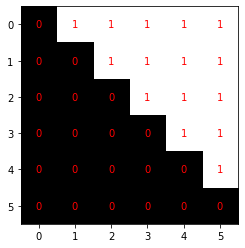

In [9]:
tensor = lookahead_mask(input_sentence)
plot_tensor(tensor)

2024-01-23 15:59:11.079 | INFO     | __main__:generate_mask:78 - Created empty mask with shape (6, 6)
2024-01-23 15:59:11.079 | DEBUG    | __main__:generate_mask:84 - Extracted tokens info:
[{'text': 'looking', 'pos': 'VERB', 'tag': 'VBG', 'position': 2, 'children': [{'text': 'Apple', 'pos': 'PROPN', 'tag': 'NNP', 'position': 0, 'children': []}, {'text': 'is', 'pos': 'AUX', 'tag': 'VBZ', 'position': 1, 'children': []}, {'text': 'at', 'pos': 'ADP', 'tag': 'IN', 'position': 3, 'children': [{'text': 'buying', 'pos': 'VERB', 'tag': 'VBG', 'position': 4, 'children': [{'text': 'U.K.', 'pos': 'PROPN', 'tag': 'NNP', 'position': 5, 'children': []}]}]}]}]
2024-01-23 15:59:11.079 | INFO     | __main__:generate_mask:87 - Mask filled for Apple is looking at buying U.K.


2024-01-23 15:59:11.087 | DEBUG    | __main__:generate_mask:88 - Created mask:
[[1. 0. 1. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0.]
 [0. 0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 1. 1.]]


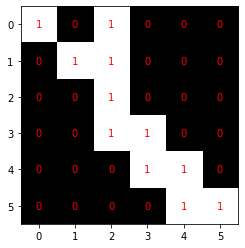

In [10]:
tensor = mask_gen.generate_mask(input_sentence)
plot_tensor(tensor)

In [11]:
import numpy as np

def generate_stochastic_matrix(size):
    if size <= 0:
        raise ValueError("Rozmiar macierzy musi być większy niż 0")

    matrix = np.zeros((size, size))

    sums = np.ones((2, size))  # pierwszy wiersz to suma wierszy, drugi to suma kolumn 

    for i in range(size):
        if i!=size-1:
            matrix[i, i] = np.round(np.random.uniform(0.3, 0.55), 2)
            sums[0,i]-=matrix[i, i]
            sums[1][i]-=matrix[i,i]
        for j in range(size-1):
            if i==j:
                continue
            value = np.round(np.random.uniform(0.01, 0.5*np.min([sums[0][i], sums[1][j]])), 2)
            sums[0][i] -= value
            sums[1][j] -= value
            matrix[i, j] = value
        matrix[i][size-1] = np.round(sums[0][i],2)
    return matrix


In [12]:
def multiply_elementwise(matrix1, matrix2):
    result_matrix = [[0 for _ in range(len(matrix1[0]))] for _ in range(len(matrix1))]

    for i in range(len(matrix1)):
        for j in range(len(matrix1[0])):
            result_matrix[i][j] = matrix1[i][j] * matrix2[i][j]

    return result_matrix


In [13]:
def plot_matrix(matrix):
    plt.imshow(matrix, cmap='viridis', interpolation='nearest')
    for i in range(len(matrix)):
        for j in range(len(matrix[0])):
            plt.text(j, i, str(matrix[i][j]), ha='center', va='center', color='w')

2024-01-23 15:59:33.077 | INFO     | __main__:__init__:34 - Loaded en_core_web_sm
2024-01-23 15:59:33.085 | INFO     | __main__:generate_mask:78 - Created empty mask with shape (6, 6)
2024-01-23 15:59:33.085 | DEBUG    | __main__:generate_mask:84 - Extracted tokens info:
[{'text': 'looking', 'pos': 'VERB', 'tag': 'VBG', 'position': 2, 'children': [{'text': 'Apple', 'pos': 'PROPN', 'tag': 'NNP', 'position': 0, 'children': []}, {'text': 'is', 'pos': 'AUX', 'tag': 'VBZ', 'position': 1, 'children': []}, {'text': 'at', 'pos': 'ADP', 'tag': 'IN', 'position': 3, 'children': [{'text': 'buying', 'pos': 'VERB', 'tag': 'VBG', 'position': 4, 'children': [{'text': 'U.K.', 'pos': 'PROPN', 'tag': 'NNP', 'position': 5, 'children': []}]}]}]}]
2024-01-23 15:59:33.094 | INFO     | __main__:generate_mask:87 - Mask filled for Apple is looking at buying U.K.
2024-01-23 15:59:33.094 | DEBUG    | __main__:generate_mask:88 - Created mask:
[[1. 0. 1. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1

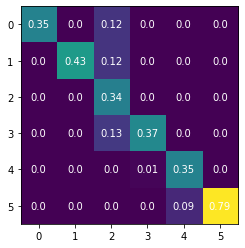

In [14]:
matrix1 =  MaskGenerator().generate_mask(input_sentence)
matrix2 = generate_stochastic_matrix(input_sentence_len)
plot_matrix( multiply_elementwise(matrix1, matrix2))